<a href="https://colab.research.google.com/github/Alonso94/GSoC-DGP/blob/master/test_MGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from mpl_toolkits.mplot3d import Axes3D
from tensorflow_probability import distributions as tfd
from tensorflow_probability import positive_semidefinite_kernels as tfk

from IPython.display import clear_output

%pylab inline
plt.rcParams['axes.facecolor']='white'
%config InlineBackend.figure_format="png"

logdir = "logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


Populating the interactive namespace from numpy and matplotlib


In [0]:
#sess=tf.InteractiveSession()
dtype=np.float64

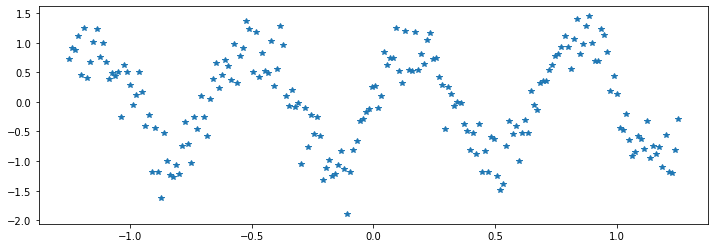

In [0]:
# test matplot
plt.figure(figsize=(12,4))
x=np.linspace(-1.25,1.25,200)
y= np.sin(3*np.pi*x)
y=y+np.random.normal(loc=0,scale=np.sqrt(0.1),size=200)
plt.plot(x,y,'*')
plt.show()

In [0]:
layer_count=0
DGP_count=0
class Layer:
    loss=None
    # input size for the next layers will be equal to the latent variable size of the previous layer
    def __init__(self, sess, input_size, output_size, DGP_output_size, input_layer=False, limit=1.25,
               a_initial_val=2.0, ls_initial_val=2.0, obs_nv_initial_val=1e-5):
        # parameter initialization from the paper
        global layer_count
        layer_count+=1;
        global DGP_count
        self.output_size=output_size
        self.input_size=input_size
        self.layer_count=layer_count
        with tf.variable_scope("DGP_{}_layer_{}".format(DGP_count,layer_count)):
            # generate training variable of the layer
            # a - amplitude
            # ls - length scale
            # obs_nv - observation noise variance
            # these variables will be optimized during the training

            # finfo : Machine limits for floating point types
            # tiny : The smallest positive usable numbe
            # softplus: a smooth approximation of a rectifier 
            # rectifier(x) = max(0,x)
            # softplus(x) = log(1+exp(x))
            tiny=np.finfo(np.float64).tiny

            a_variable=tf.Variable(initial_value=a_initial_val,name="amplitude",dtype=dtype)
            self.a=(tiny + tf.nn.softplus(a_variable))

            ls_variable=tf.Variable(initial_value=ls_initial_val,name="length_scale",dtype=dtype)
            self.ls=(tiny + tf.nn.softplus(ls_variable))

            obs_nv_variable=tf.Variable(initial_value=obs_nv_initial_val,name="observation_noise_variance",dtype=dtype)
            self.obs_nv=(tiny + tf.nn.softplus(obs_nv_variable))

            # use Exponentiated quadratic kernel
            # or could be called squared exponential, Gaussian, or radial basis function
            # k(x, y) = amplitude**2 * exp(-||x - y||**2 / (2 * length_scale**2))
            self.kernel = tfk.ExponentiatedQuadratic( self.a, self.ls )

            # define the number of the inducing points
            # number of the inducing points from the paper
            self.num_inducing_points=100

            # we have to make trainable inducing points
            init_inducing=np.linspace(-limit,limit,self.num_inducing_points,dtype)[...,newaxis]
            self.inducing_ind_pts=tf.Variable(init_inducing,dtype=np.float64,name='inducing_index_points')

            init_loc=np.zeros([self.num_inducing_points],dtype=dtype)
            self.variational_ind_obs_loc=tf.Variable(init_loc,name="variational_inducing_observations_loc")

            init_scale=np.eye(self.num_inducing_points,dtype=dtype)
            self.variational_ind_obs_scale=tf.Variable(init_scale,name="variational_inducing_observations_scale")

            self.input_placeholder = tf.placeholder(dtype, [None,input_size], name='layer_input')

            self.posteriors=[]
            self.priors=[]
            self.optimizer=[]
            self.train_op=[]
            self.loss=[0.0]*output_size
            
            # construct the VGP distribution(s)
            for i in range(output_size):
                
                self.priors.append(tfd.GaussianProcess(kernel=tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(),
                                                    index_points=self.input_placeholder))
                
                self.posteriors.append(tfd.VariationalGaussianProcess(kernel=self.kernel,
                                                                    index_points=self.input_placeholder,
                                                                    inducing_index_points=self.inducing_ind_pts,
                                                                    variational_inducing_observations_loc=self.variational_ind_obs_loc,
                                                                    variational_inducing_observations_scale=self.variational_ind_obs_scale))

    def _sample(self,sess):
        samples=[]
        for posterior in self.posteriors:
            samples.append(posterior.sample())
        return samples
    
    def update_prior(self,sess):
        for i in range(len(self.priors)):
            self.priors[i]= self.posteriors[i]



In [0]:
class DGP:
    def __init__(self, X, Y, num_hidden_layers=2, latent_size=1):
        global DGP_count
        DGP_count+=1

        global layer_cont
        layer_count=0

        input_size=X.shape[1]
        output_size=Y.shape[1]

        self.input_size=input_size
        self.output_size=output_size
        self.num_hidden_layers=num_hidden_layers
        self.latent_size=latent_size

        self.X=X
        self.Y=Y

        self.layers=[]
        self.xs=[]
        self.ys=[]
        
        self.sess=tf.Session()

        self.build_model(self.sess)
        
        self.input_placeholder=tf.placeholder(dtype,[None,self.input_size],name="DGP_input")
        self.output_placeholder=tf.placeholder(dtype,[None,self.output_size],name="DGP_output")
        
        self.loss_ = abs(self.loss(self.sess))
        
        ## learning rate from the paper
        self.optimizer=tf.train.AdamOptimizer(learning_rate=0.01)
        self.train_op=self.optimizer.minimize(self.loss_)
            
        self.sess.run(tf.initialize_all_variables())  

    def build_model(self,sess):
        self.layers.append(Layer(sess,self.input_size,self.latent_size,self.output_size))
        for i in range(self.num_hidden_layers):
            self.layers.append(Layer(sess,self.latent_size,self.latent_size,self.output_size))
        self.layers.append(Layer(sess,self.latent_size,self.output_size,self.output_size))
    
    def loss(self,sess):
        ################################################
        ##
        ##   (Equation 17 - Doubly stochastic DGP paper)
        ##
        ###############################################
        loss=0.0
        kl_term=0.0
        k=0
        for layer in self.layers:
            print(k)
            k+=1
            for i in range(layer.output_size):
                kl=layer.posteriors[i].kl_divergence(layer.priors[i])
                kl_term+=tf.reduce_mean(kl)
            posteriors=layer.posteriors
        lh_term=0.0
        for posterior in posteriors:
            lh=posterior.log_prob(self.Y)
            lh=tf.reduce_sum(lh,axis=-1)
            lh_term=tf.reduce_mean(lh)
        loss = lh_term - kl_term
        return loss
            
    def train(self,niter=20000):
        for i in range(niter):
            x=self.X
            feed_dict={}
            for j in range(len(self.layers)):
                feed_dict[self.layers[j].input_placeholder]=x
                self.sample=self.layers[j]._sample(self.sess)
                x=self.sess.run(self.sample,feed_dict={self.layers[j].input_placeholder:x})
                x=np.array(x).T
#                 print(self.sess.run([self.layers[j].a,self.layers[j].ls,self.layers[j].obs_nv]))
            loss,_=self.sess.run([self.loss_,self.train_op],feed_dict=feed_dict)
            self.plot_loss(i,loss)
            
    def plot_loss(self,x,y):
        if len(self.xs)==0:
            fig=plt.figure()
        self.xs.append(x)
        self.ys.append(y)
        clear_output(wait=True)
        plt.plot(self.xs,self.ys,label='training loss')
        plt.xlabel("Number of iterations")
        plt.ylabel("loss")
        plt.legend()
        plt.show()
        
    def predict(self,X):
        Y=[]
        f_i=x
        count=1
        for layer in self.layers:
            f_i=f_i.reshape((-1,1))
            feed_dict={layer.input_placeholder:f_i}
            for i in range(layer.output_size):
                ################################################
                ##
                ##   (Equation 15 - Doubly stochastic DGP paper)
                ##
                ################################################

                posterior=layer.posteriors[i]
                mean=posterior.mean()
                covariance=posterior.scale.matmul(posterior.scale.to_dense(), adjoint_arg=True)
                m,cov=self.sess.run([mean,covariance],feed_dict)
                first_term=m
                size=m.size
                k=np.eye(size,dtype=np.float64)
                z=np.zeros(size,dtype=np.float64)
                e=np.random.multivariate_normal(z,k)
                sqr=np.sqrt(cov)
                # TODO check sampe's variance in variational GP class
                second_term= np.dot(sqr,e)
                
                layer_pred=first_term + second_term
                f_i=layer_pred

            count+=1
            print("f_i",f_i)
        Y=f_i
        return Y


In [0]:
tf.reset_default_graph()
print(x.shape)
x=x.reshape((-1,1))
y=y.reshape((-1,1))

(200,)


In [0]:
dgp=DGP(x,y)

0
1
2
3


/home/ali/.local/lib/python3.6/site-packages/tensorflow_probability/python/distributions/gaussian_process.py:303: UserWarning: Unable to detect statically whether the number of index_points is 1. As a result, defaulting to treating the marginal GP at `index_points` as a multivariate Gaussian. This makes some methods, like `cdf` unavailable.
  'Unable to detect statically whether the number of index_points is '
W0825 08:14:34.365941 139930291136320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0825 08:14:35.098255 139930291136320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_should_use.py:193: initialize_all_variables (from tensorflow.python.ops.variables) is dep

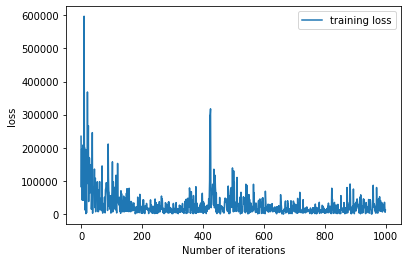

In [0]:
dgp.train(1000)

In [0]:
print(dgp.predict(x))

/home/ali/.local/lib/python3.6/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in sqrt


f_i [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
f_i [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan 